In [25]:
def clean_n_save(input_link, output_link):
    import re
    with open(input_link, "r", encoding="utf-8") as f:
        raw_text = f.read()
        low_case_raw_text = raw_text.lower()
        toned_data = re.sub(r'[\d_]+', '', low_case_raw_text)
        toned_data = re.findall(r'[\w]+', toned_data)
        poem = []
        sentence = []
        count_line = 0
        count_word = 0
        for w in toned_data:
            sentence.append(w)
            count_word += 1
            if (count_line % 2 == 0 and count_word % 6 == 0) or (count_line % 2 == 1 and count_word % 8 == 0):
                count_line += 1
                count_word = 0
                poem.append(" ".join(sentence))
                sentence = []
    with open(output_link, "w", encoding="utf-8") as f:
        f.write("\n".join(poem))


def poem_format(texts):
    poem = ''
    for w in range(len(texts.split())):
        if w != 0 and w % 14 in [13, 5]:
            poem += texts.split()[w] + '\n'
        else:
            poem += texts.split()[w] + ' '
    return poem


def tone_extractor(texts, board):
    tone = []
    for w in texts.split():
        tone.append(board.loc[board["word"] == w, "tone"].values[0])
    return poem_format(" ".join(tone))

In [26]:
import glob

for file in glob.glob("Poem/*.txt"):
    clean_n_save(file, "CleanedPoem/" + file.split("\\")[1])

In [27]:
import pandas as pd, re, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
tf.config.list_physical_devices("GPU")

[]

In [28]:
# data = ""
# for file in glob.glob("CleanedPoem/*.txt"):
#     with open(file, "r", encoding="utf-8") as f:
#         data += f.read() + "\n"
with open("CleanedPoem/TruyenKieu.txt", "r", encoding="utf-8") as f:
    data = f.read()

In [29]:
# data = """trăm năm trong cõi người ta
# chữ tài chữ mệnh khéo là ghét nhau
# trải qua một cuộc bể dâu
# những điều trông thấy mà đau đớn lòng
# lạ gì bỉ sắc tư phong
# trời xanh quen thói má hồng đánh ghen
# cảo thơm lần giở trước đèn
# phong tình có lục còn truyền sử xanh
# rằng năm gia tĩnh triều minh
# bốn phương phẳng lặng hai kinh vững vàng
# có nhà viên ngoại họ vương
# gia tư nghĩ cũng thường thường bực trung
# một trai con thứ rốt lòng
# vương quan là chữ nối dòng nho gia
# đầu lòng hai ả tố nga
# thúy kiều là chị em là thúy vân
# mai cốt cách tuyết tinh thần
# một người một vẻ mười phân vẹn mười
# vân xem trang trọng khác vời
# khuôn trăng đầy đặn nét ngài nở nang
# hoa cười ngọc thốt đoan trang
# mây thua nước tóc tuyết nhường màu da
# kiều càng sắc sảo mặn mà
# so bề tài sắc lại là phần hơn
# làn thu thủy nét xuân sơn
# hoa ghen thua thắm liễu hờn kém xanh
# một hai nghiêng nước nghiêng thành
# sắc đành đòi một tài đành họa hai
# thông minh vốn sẵn tư trời
# pha nghề thi họa đủ mùi ca ngâm
# cung thương làu bậc ngũ âm
# nghề riêng ăn đứt hồ cầm một trương
# khúc nhà tay lựa nên chương
# một thiên bạc mệnh lại càng não nhân
# phong lưu rất mực hồng quần
# xuân xanh sấp xỉ tới tuần cập kê
# êm đềm trướng rủ màn che
# tường đông ong bướm đi về mặc ai
# ngày xuân con én đưa thoi
# thiều quang chín chục đã ngoài sáu mươi
# cỏ non xanh tận chân trời
# cành lê trắng điểm một vài bông hoa
# thanh minh trong tiết tháng ba
# lễ là tảo mộ hội là đạp thanh
# gần xa nô nức yến anh
# chị em sắm sửa bộ hành chơi xuân
# dập dìu tài tử giai nhân
# ngựa xe như nước áo quần như nêm
# ngổn ngang gò đống kéo lên
# thoi vàng vó rắc tro tiền giấy bay
# tà tà bóng ngả về tây
# chị em thơ thẩn dan tay ra về
# bước dần theo ngọn tiểu khê
# lần xem phong cảnh có bề thanh thanh
# nao nao dòng nước uốn quanh
# dịp cầu nho nhỏ cuối ghềnh bắc ngang
# sè sè nấm đất bên đàng
# dàu dàu ngọn cỏ nửa vàng nửa xanh"""

In [30]:
raw_corpus = data.split("\n")
print("Số câu:", len(raw_corpus))
print("Số từ:", int(len(raw_corpus) / 2 * 14))

Số câu: 3254
Số từ: 22778


In [31]:
raw_tokenizer = Tokenizer()
raw_tokenizer.fit_on_texts(raw_corpus)
total_words = len(raw_tokenizer.word_index) + 1
tokens = raw_tokenizer.word_index
raw_sequence = raw_tokenizer.texts_to_sequences(raw_corpus)
raw_sequence = pad_sequences(raw_sequence)

In [32]:
tokens = pd.DataFrame(tokens.items(), columns=["word", "index"])
tokens.set_index("index", inplace=True)

vowels = "aeuoiyáàạảãâấầậẩẫăắằặẳẵéèẹẻẽêếềệểễóòọỏõôốồộổỗơớờợởỡúùụủũưứừựửữíìịỉĩýỳỵỷỹ"
# tokens["toneless"] = ""
tokens["prefix"] = ""
tokens["suffix"] = ""
tokens["tone"] = "_"
tokens["tone type"] = "bằng"

for token in tokens["word"]:
    suffix = ""
    for char in token:
        if char in vowels:
            tokens['prefix'][tokens["word"] == token] = token[:token.index(char)]
            suffix = token[token.index(char):]
            break

    for i in suffix:
        if i in vowels[6:]:
            if i in ["à", "ằ", "ầ", "è", "ề", "ì", "ò", "ồ", "ờ", "ù", "ừ", "ỳ"]:
                tokens["tone"][tokens["word"] == token] = "f"
                tokens["tone type"][tokens["word"] == token] = "bằng"
            elif i in ["á", "ắ", "ấ", "é", "ế", "í", "ó", "ố", "ớ", "ú", "ứ", "ý"]:
                tokens["tone"][tokens["word"] == token] = "s"
                tokens["tone type"][tokens["word"] == token] = "trắc"
            elif i in ["ạ", "ặ", "ậ", "ẹ", "ệ", "ị", "ọ", "ộ", "ợ", "ụ", "ự", "ỵ"]:
                tokens["tone"][tokens["word"] == token] = "j"
                tokens["tone type"][tokens["word"] == token] = "trắc"
            elif i in ["ả", "ẳ", "ẩ", "ẻ", "ể", "ỉ", "ỏ", "ổ", "ở", "ủ", "ử", "ỷ"]:
                tokens["tone"][tokens["word"] == token] = "r"
                tokens["tone type"][tokens["word"] == token] = "trắc"
            elif i in ["ã", "ẵ", "ẫ", "ẽ", "ễ", "ĩ", "õ", "ỗ", "ỡ", "ũ", "ữ", "ỹ"]:
                tokens["tone"][tokens["word"] == token] = "x"
                tokens["tone type"][tokens["word"] == token] = "trắc"

    suffix = re.sub(r"[áàạảã]", "a", suffix)
    suffix = re.sub(r"[ắằặẳẵ]", "ă", suffix)
    suffix = re.sub(r"[ấầậẩẫ]", "â", suffix)
    suffix = re.sub(r"[éèẹẻẽ]", "e", suffix)
    suffix = re.sub(r"[ếềệểễ]", "ê", suffix)
    suffix = re.sub(r"[óòọỏõ]", "o", suffix)
    suffix = re.sub(r"[ốồộổỗ]", "ô", suffix)
    suffix = re.sub(r"[ớờợởỡ]", "ơ", suffix)
    suffix = re.sub(r"[úùụủũ]", "u", suffix)
    suffix = re.sub(r"[ứừựửữ]", "ư", suffix)
    suffix = re.sub(r"[íìịỉĩ]", "i", suffix)
    suffix = re.sub(r"[ýỳỵỷỹ]", "y", suffix)
    tokens["suffix"][tokens["word"] == token] = suffix
    
    # tokens["toneless"][tokens["word"] == token] = tokens["prefix"][tokens["word"] == token].values[0] + tokens["suffix"][tokens["word"] == token].values[0]

tokens

,word,prefix,suffix,tone,tone type
index,,,,,
1,một,m,ôt,j,trắc
2,đã,đ,a,x,trắc
3,người,ng,ươi,f,bằng
4,nàng,n,ang,f,bằng
5,lòng,l,ong,f,bằng
...,...,...,...,...,...
2383,ngạch,ng,ach,j,trắc
2384,len,l,en,_,bằng
2385,hái,h,ai,s,trắc


In [33]:
# toneless_corpus = []
# for word in data.split():
#     toneless_corpus.append(tokens.loc[tokens["word"] == word, "toneless"].values[0])
# toneless_corpus = poem_format(" ".join(toneless_corpus)).split("\n")
# 
# toneless_tokenizer = Tokenizer()
# toneless_tokenizer.fit_on_texts(toneless_corpus)
# toneless_sequence = toneless_tokenizer.texts_to_sequences(toneless_corpus)
# toneless_sequence = pad_sequences(toneless_sequence)

In [34]:
# rhythm_corpus = []
# for word in data.split():
#     rhythm_corpus.append(tokens.loc[tokens["word"] == word, "tone"].values[0])
# rhythm_corpus = poem_format(" ".join(rhythm_corpus)).split("\n")
# 
# rhythm_tokenizer = Tokenizer()
# rhythm_tokenizer.fit_on_texts(rhythm_corpus)
# rhythm_sequence = rhythm_tokenizer.texts_to_sequences(rhythm_corpus)
# rhythm_sequence = pad_sequences(rhythm_sequence)

In [35]:
raw_input_sequences = []
for line in raw_corpus:
    raw_token_list = raw_tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(raw_token_list)):
        raw_n_gram_sequence = raw_token_list[:i + 1]
        raw_input_sequences.append(raw_n_gram_sequence)

In [36]:
# toneless_input_sequences = []
# for line in toneless_corpus:
#     toneless_token_list = toneless_tokenizer.texts_to_sequences([line])[0]
#     for i in range(1, len(toneless_token_list)):
#         toneless_n_gram_sequence = toneless_token_list[:i + 1]
#         toneless_input_sequences.append(toneless_n_gram_sequence)

In [37]:
# rhythm_input_sequences = []
# for line in rhythm_corpus:
#     rhythm_token_list = rhythm_tokenizer.texts_to_sequences([line])[0]
#     for i in range(1, len(rhythm_token_list)):
#         rhythm_n_gram_sequence = rhythm_token_list[:i + 1]
#         rhythm_input_sequences.append(rhythm_n_gram_sequence)

In [38]:
max_sequence_len = max([len(x) for x in raw_input_sequences])
raw_input_sequences = pad_sequences(raw_input_sequences, maxlen=max_sequence_len, padding="pre")
# toneless_input_sequences = pad_sequences(toneless_input_sequences, maxlen=max_sequence_len, padding="pre")
# rhythm_input_sequences = pad_sequences(rhythm_input_sequences, maxlen=max_sequence_len, padding="pre")

In [39]:
xs_raw, labels_raw = raw_input_sequences[:, :-1], raw_input_sequences[:, -1]
ys_raw = tf.keras.utils.to_categorical(labels_raw, num_classes=total_words)

# xs_toneless, labels_toneless = toneless_input_sequences[:, :-1], toneless_input_sequences[:, -1]
# ys_toneless = tf.keras.utils.to_categorical(labels_toneless, num_classes=total_words)

# xs_rhythm, labels_rhythm = rhythm_input_sequences[:, :-1], rhythm_input_sequences[:, -1]
# ys_rhythm = tf.keras.utils.to_categorical(labels_rhythm, num_classes=total_words)

In [40]:
raw_model = keras.Sequential([
    keras.layers.Embedding(total_words, 100, input_length=max_sequence_len - 1),
    keras.layers.Bidirectional(keras.layers.LSTM(28, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(30)),
    keras.layers.Dense(total_words / 2, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(total_words, activation="softmax")
])

# toneless_model = keras.Sequential([
#     keras.layers.Embedding(total_words, 100, input_length=max_sequence_len - 1),
#     keras.layers.Bidirectional(keras.layers.LSTM(150, return_sequences=True)),
#     keras.layers.LSTM(100),
#     keras.layers.Dense(total_words / 2, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
#     keras.layers.Dense(total_words, activation="softmax")
# ])

# rhythm_model = keras.Sequential([
#     keras.layers.Embedding(total_words, 100, input_length=max_sequence_len - 1),
#     keras.layers.Bidirectional(keras.layers.LSTM(150, return_sequences=True)),
#     keras.layers.LSTM(100),
#     keras.layers.Dense(total_words / 2, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
#     keras.layers.Dense(total_words, activation="softmax")
# ])

with tf.device("/GPU:0"):
    raw_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    raw_history = raw_model.fit(xs_raw, ys_raw, epochs=120, verbose=1)

    # toneless_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    # toneless_history = toneless_model.fit(xs_toneless, ys_toneless, epochs=120, verbose=1)

    # rhythm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    # rhythm_history = rhythm_model.fit(xs_rhythm, ys_rhythm, epochs=120, verbose=1)

Epoch 1/120
611/611 [==============================] - 16s 18ms/step - loss: 7.0730 - accuracy: 0.0114
Epoch 2/120
611/611 [==============================] - 12s 19ms/step - loss: 6.7921 - accuracy: 0.0125
Epoch 3/120
611/611 [==============================] - 11s 19ms/step - loss: 6.7181 - accuracy: 0.0145
Epoch 4/120
611/611 [==============================] - 11s 19ms/step - loss: 6.6189 - accuracy: 0.0200
Epoch 5/120
611/611 [==============================] - 11s 18ms/step - loss: 6.4544 - accuracy: 0.0236
Epoch 6/120
611/611 [==============================] - 11s 18ms/step - loss: 6.2972 - accuracy: 0.0272
Epoch 7/120
611/611 [==============================] - 11s 18ms/step - loss: 6.1434 - accuracy: 0.0308
Epoch 8/120
611/611 [==============================] - 11s 18ms/step - loss: 6.0221 - accuracy: 0.0311
Epoch 9/120
611/611 [==============================] - 11s 19ms/step - loss: 5.9153 - accuracy: 0.0353
Epoch 10/120
611/611 [==============================] - 11s 19ms/step - l

In [41]:
import matplotlib.pyplot as plt

In [42]:
def plot_graphs(history, string, title):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title(title)
    plt.show()

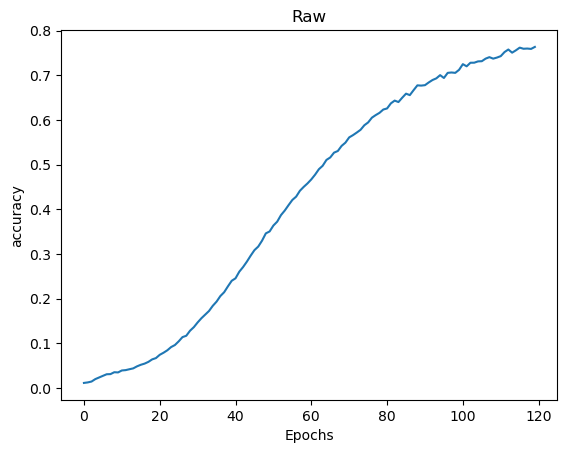

In [43]:
plot_graphs(raw_history, "accuracy", "Raw")

In [44]:
# plot_graphs(toneless_history, "accuracy", "Toneless")

In [45]:
# plot_graphs(rhythm_history, "accuracy", "Rhythm")

In [46]:
# def add_tone(toneless, tone):
#     toneless_vowels = "aeuoiyăâưôơ"
#     tone_index = 0
# 
#     for character in range(len(toneless)):
#         if toneless[character] in toneless_vowels:
#             tone_index = character
#             break
# 
#     if toneless[tone_index] == "a":
#         if tone == "f":
#             return re.sub(r"a", "à", toneless)
#         elif tone == "s":
#             return re.sub(r"a", "á", toneless)
#         elif tone == "j":
#             return re.sub(r"a", "ạ", toneless)
#         elif tone == "r":
#             return re.sub(r"a", "ả", toneless)
#         elif tone == "x":
#             return re.sub(r"a", "ã", toneless)
#     elif toneless[tone_index] == "ă":
#         if tone == "f":
#             return re.sub(r"ă", "ằ", toneless)
#         elif tone == "s":
#             return re.sub(r"ă", "ắ", toneless)
#         elif tone == "j":
#             return re.sub(r"ă", "ặ", toneless)
#         elif tone == "r":
#             return re.sub(r"ă", "ẳ", toneless)
#         elif tone == "x":
#             return re.sub(r"ă", "ẵ", toneless)
#     elif toneless[tone_index] == "â":
#         if tone == "f":
#             return re.sub(r"â", "ầ", toneless)
#         elif tone == "s":
#             return re.sub(r"â", "ấ", toneless)
#         elif tone == "j":
#             return re.sub(r"â", "ậ", toneless)
#         elif tone == "r":
#             return re.sub(r"â", "ẩ", toneless)
#         elif tone == "x":
#             return re.sub(r"â", "ẫ", toneless)
#     elif toneless[tone_index] == "e":
#         if tone == "f":
#             return re.sub(r"e", "è", toneless)
#         elif tone == "s":
#             return re.sub(r"e", "é", toneless)
#         elif tone == "j":
#             return re.sub(r"e", "ẹ", toneless)
#         elif tone == "r":
#             return re.sub(r"e", "ẻ", toneless)
#         elif tone == "x":
#             return re.sub(r"e", "ẽ", toneless)
#     elif toneless[tone_index] == "ê":
#         if tone == "f":
#             return re.sub(r"ê", "ề", toneless)
#         elif tone == "s":
#             return re.sub(r"ê", "ế", toneless)
#         elif tone == "j":
#             return re.sub(r"ê", "ệ", toneless)
#         elif tone == "r":
#             return re.sub(r"ê", "ể", toneless)
#         elif tone == "x":
#             return re.sub(r"ê", "ễ", toneless)
#     elif toneless[tone_index] == "o":
#         if tone == "f":
#             return re.sub(r"o", "ò", toneless)
#         elif tone == "s":
#             return re.sub(r"o", "ó", toneless)
#         elif tone == "j":
#             return re.sub(r"o", "ọ", toneless)
#         elif tone == "r":
#             return re.sub(r"o", "ỏ", toneless)
#         elif tone == "x":
#             return re.sub(r"o", "õ", toneless)
#     elif toneless[tone_index] == "ơ":
#         if tone == "f":
#             return re.sub(r"ơ", "ờ", toneless)
#         elif tone == "s":
#             return re.sub(r"ơ", "ớ", toneless)
#         elif tone == "j":
#             return re.sub(r"ơ", "ợ", toneless)
#         elif tone == "r":
#             return re.sub(r"ơ", "ở", toneless)
#         elif tone == "x":
#             return re.sub(r"ơ", "ỡ", toneless)
#     elif toneless[tone_index] == "ô":
#         if tone == "f":
#             return re.sub(r"ô", "ồ", toneless)
#         elif tone == "s":
#             return re.sub(r"ô", "ố", toneless)
#         elif tone == "j":
#             return re.sub(r"ô", "ộ", toneless)
#         elif tone == "r":
#             return re.sub(r"ô", "ổ", toneless)
#         elif tone == "x":
#             return re.sub(r"ô", "ỗ", toneless)
#     elif toneless[tone_index] == "u":
#         if tone == "f":
#             return re.sub(r"u", "ù", toneless)
#         elif tone == "s":
#             return re.sub(r"u", "ú", toneless)
#         elif tone == "j":
#             return re.sub(r"u", "ụ", toneless)
#         elif tone == "r":
#             return re.sub(r"u", "ủ", toneless)
#         elif tone == "x":
#             return re.sub(r"u", "ũ", toneless)
#     elif toneless[tone_index] == "ư":
#         if tone == "f":
#             return re.sub(r"ư", "ừ", toneless)
#         elif tone == "s":
#             return re.sub(r"ư", "ứ", toneless)
#         elif tone == "j":
#             return re.sub(r"ư", "ự", toneless)
#         elif tone == "r":
#             return re.sub(r"ư", "ử", toneless)
#         elif tone == "x":
#             return re.sub(r"ư", "ữ", toneless)
#     elif toneless[tone_index] == "i":
#         if tone == "f":
#             return re.sub(r"i", "ì", toneless)
#         elif tone == "s":
#             return re.sub(r"i", "í", toneless)
#         elif tone == "j":
#             return re.sub(r"i", "ị", toneless)
#         elif tone == "r":
#             return re.sub(r"i", "ỉ", toneless)
#         elif tone == "x":
#             return re.sub(r"i", "ĩ", toneless)
#     elif toneless[tone_index] == "y":
#         if tone == "f":
#             return re.sub(r"y", "ỳ", toneless)
#         elif tone == "s":
#             return re.sub(r"y", "ý", toneless)
#         elif tone == "j":
#             return re.sub(r"y", "ỵ", toneless)
#         elif tone == "r":
#             return re.sub(r"y", "ỷ", toneless)
#         elif tone == "x":
#             return re.sub(r"y", "ỹ", toneless)


def qualify_next_word(seed, output_list, board):
    poem = poem_format(seed).split("\n")
    output_list = raw_tokenizer.sequences_to_texts([output_list])[0].split(" ")
    # print(output_list)
    if poem[1] == "":
        poem = [poem[0]]
    current = (len(poem) - 1, len(poem[-1].split()) - 1)
    
    if current[1] == 4 and current[0] != 0:
        for output in output_list:
            # if board.loc[board["word"] == output, "tone"].values[0] == rhythm:
            if board.loc[board["word"] == output, "suffix"].values[0] == \
                    board.loc[board["word"] == poem[-2].split(" ")[-1], "suffix"].values[0]:
                return output
        return poem[-2].split(" ")[-1]   
        
    else:
        # for output in output_list:
        #     if board.loc[board["word"] == output, "tone"].values[0] == rhythm:
        #         return output
        return output_list[0]

# def qualify_next_word(seed, rhythm, output_list, board):
#     poem = poem_format(seed).split("\n")
#     outputs = toneless_tokenizer.sequences_to_texts([output_list])[0].split(" ")
#     if poem[1] == "":
#         poem = [poem[0]]
#     current = (len(poem) - 1, len(poem[-1].split()) - 1)
#     qualified = ""
#     if current[1] == 4 and current[0] != 0:
#         for output in outputs:
#             if board.loc[board["toneless"] == output, "suffix"].values[0] == \
#                     board.loc[board["word"] == poem[current[0] - 1][-1], "suffix"].values[0]:
#                 qualified = add_tone(output, rhythm)
#                 board.loc[len(board)] = [qualified, output,
#                                          board.loc[board["toneless"] == output, "prefix"].values[0],
#                                          board.loc[board["toneless"] == output, "suffix"].values[0],
#                                          board.loc[board["toneless"] == output, "tone"].values[0],
#                                          board.loc[board["toneless"] == output, "tone type"].values[0]]
#         qualified = add_tone(poem[-2].split()[-1], rhythm)
#         board.loc[len(board)] = [qualified, poem[-2].split()[-1],
#                                  board.loc[board["toneless"] == poem[-2].split()[-1], "prefix"].values[0],
#                                  board.loc[board["toneless"] == poem[-2].split()[-1], "suffix"].values[0],
#                                  board.loc[board["toneless"] == poem[-2].split()[-1], "tone"].values[0],
#                                  board.loc[board["toneless"] == poem[-2].split()[-1], "tone type"].values[0]]
#     else:
#         qualified = add_tone(board.loc[[output_list[0]], "toneless"].values[0], rhythm)
#         board.loc[len(board)] = [qualified, board.loc[[output_list[0]], "toneless"].values[0],
#                                  board.loc[board["toneless"] == board.loc[[output_list[0]], "toneless"].values[0], "prefix"].values[0],
#                                  board.loc[board["toneless"] == board.loc[[output_list[0]], "toneless"].values[0], "suffix"].values[0],
#                                  board.loc[board["toneless"] == board.loc[[output_list[0]], "toneless"].values[0], "tone"].values[0],
#                                  board.loc[board["toneless"] == board.loc[[output_list[0]], "toneless"].values[0], "tone type"].values[0]]
#     return qualified, board

In [47]:
seed_text = "trăm năm trong cõi người ta"
# rhythm_seed_text = tone_extractor(seed_text, tokens)
next_lines = 10
words = 0
if next_lines % 2 == 0:
    words = int(next_lines / 2 * 14)
else:
    words = int((next_lines - 1) / 2 * 14) + 6

for i in range(words):
    # rhythm_token_list = rhythm_tokenizer.texts_to_sequences([rhythm_seed_text])[0]
    # rhythm_token_list = pad_sequences([rhythm_token_list], maxlen=max_sequence_len - 1, padding="pre")
    # predicted_rhythm = np.argmax(rhythm_model.predict(rhythm_token_list), axis=1)
    # 
    # output_rhythm = ""
    # for word, index in rhythm_tokenizer.word_index.items():
    #     if index == predicted_rhythm:
    #         output_rhythm = word
    #         break

    raw_token_list = raw_tokenizer.texts_to_sequences([seed_text])[0]
    print(raw_token_list)
    raw_token_list = pad_sequences([raw_token_list], maxlen=max_sequence_len - 1, padding="pre")
    predicted_raw = np.argsort(raw_model.predict(raw_token_list), axis=1)[::-1][0]
    predicted_raw = predicted_raw[predicted_raw != 0]

    # toneless_token_list = toneless_tokenizer.texts_to_sequences([seed_text])[0]
    # toneless_token_list = pad_sequences([toneless_token_list], maxlen=max_sequence_len - 1, padding="pre")
    # predicted_toneless = np.argsort(toneless_model.predict(toneless_token_list), axis=1)[::-1][0]
    # predicted_toneless = predicted_toneless[predicted_toneless != 0]

    next_word = qualify_next_word(seed_text, predicted_raw, tokens)
    seed_text += " " + next_word
    # rhythm_seed_text += " " + output_rhythm
    # print(rhythm_seed_text)

[140, 76, 26, 497, 3, 65]
1/1 [==============================] - 1s 1s/step
[140, 76, 26, 497, 3, 65, 1639]
1/1 [==============================] - 0s 17ms/step
[140, 76, 26, 497, 3, 65, 1639, 2387]
1/1 [==============================] - 0s 19ms/step
[140, 76, 26, 497, 3, 65, 1639, 2387, 757]
1/1 [==============================] - 0s 19ms/step
[140, 76, 26, 497, 3, 65, 1639, 2387, 757, 734]
1/1 [==============================] - 0s 18ms/step
[140, 76, 26, 497, 3, 65, 1639, 2387, 757, 734, 1307]
1/1 [==============================] - 0s 20ms/step
[140, 76, 26, 497, 3, 65, 1639, 2387, 757, 734, 1307, 1762]
1/1 [==============================] - 0s 20ms/step
[140, 76, 26, 497, 3, 65, 1639, 2387, 757, 734, 1307, 1762, 640]
1/1 [==============================] - 0s 19ms/step
[140, 76, 26, 497, 3, 65, 1639, 2387, 757, 734, 1307, 1762, 640, 1510]
1/1 [==============================] - 0s 18ms/step
[140, 76, 26, 497, 3, 65, 1639, 2387, 757, 734, 1307, 1762, 640, 1510, 1313]
1/1 [===============

In [48]:
print(poem_format(seed_text))

trăm năm trong cõi người ta
lèo lẫn vững rắp nguyện nhã cúi thệ
túc yếu bụng định tuông hễ
tốc ví số tô đội tế vĩnh gột
chịu hoài hoài luồn hoài gột
lưới cố lẫn lẫn phổ thốt lẫn gác
dẫn kiếm trà trú hoài phác
thệ tạm vin quả ôi tạc chạm tạm
sảo kiếm lẫn an lẫn tam
chịu làu oán chốn sấm chàm kè rượu
bộc hoài hoài thời co rượu
